# Filters in Seismology with ObsPy
## Highpass, Lowpass, Bandpass • One-way (causal) vs Two-way (zero-phase) • Minimum-phase vs Zero-phase • Onset smearing

This notebook is a hands-on introduction to filtering, using **ObsPy** idioms (`Trace.filter()`).

You will learn:
- What **highpass**, **lowpass**, and **bandpass** filters do
- The difference between **one-way (causal)** and **two-way (zero-phase / acausal)** filtering in ObsPy (`zerophase=False/True`)
- Why **zero-phase does not “shift” waveforms** but **can smear energy before an onset** (pre-ringing)
- How filter **order/corners** affects cutoff sharpness and ringing
- How to visualize outputs in the **time domain** and **frequency domain**
- A wrap-up section on **analog vs digital** thinking (what’s different in practice)

> We speak with *analog intuition* (frequency content, phase, causality),  
> but the code applies **digital filters** to sampled data (as you actually do in seismology).



## 0) Setup

We’ll use:
- `numpy` and `matplotlib` for plotting and FFTs
- `obspy` for filtering

If you need ObsPy:
```bash
conda install -c conda-forge obspy
# or
pip install obspy
```


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime

# -------- Plot helpers (keep simple; no special styling/colors) --------

def plot_time(t, x, title="", xlabel="Time (s)", ylabel="Amplitude", xlim=None):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(t, x)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if xlim is not None:
        ax.set_xlim(*xlim)
    plt.show()

def amp_spectrum(x, fs, nfft=None):
    x = np.asarray(x)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(x))))
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    return f, np.abs(X)

def plot_spectrum(x, fs, title="", xlim=(0, None), nfft=None):
    f, mag = amp_spectrum(x, fs, nfft=nfft)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(f, mag)
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("|X(f)|")
    ax.grid(True, alpha=0.3)
    if xlim[1] is None:
        ax.set_xlim(xlim[0], fs/2)
    else:
        ax.set_xlim(*xlim)
    plt.show()

def make_trace(x, fs, starttime=None):
    tr = Trace(data=np.asarray(x, dtype=np.float64).copy())
    tr.stats.sampling_rate = float(fs)
    tr.stats.starttime = UTCDateTime(0) if starttime is None else starttime
    return tr



## 1) Core ideas (analog intuition)

### Lowpass
Passes **low frequencies**, attenuates high frequencies.
- Use for: removing high-frequency noise; smoothing; isolating long-period components

### Highpass
Passes **high frequencies**, attenuates low frequencies.
- Use for: removing drift/offsets/steps; emphasizing sharper arrivals (P/S)

### Bandpass
Passes a **range** of frequencies.
- Use for: isolating a band where the SNR is best (P-band, LP-band, tremor-band)

In *analog* terms we talk about frequency content and phase.  
In *practice* we implement filters digitally on sampled data.



## 2) Create a synthetic seismogram (signal + drift + noise)

We’ll build:
- a sharp “P-like” onset (Ricker wavelet)
- a later lower-frequency “LP-like” feature
- a slow drift and noise

Then we’ll compare different filters and application methods.


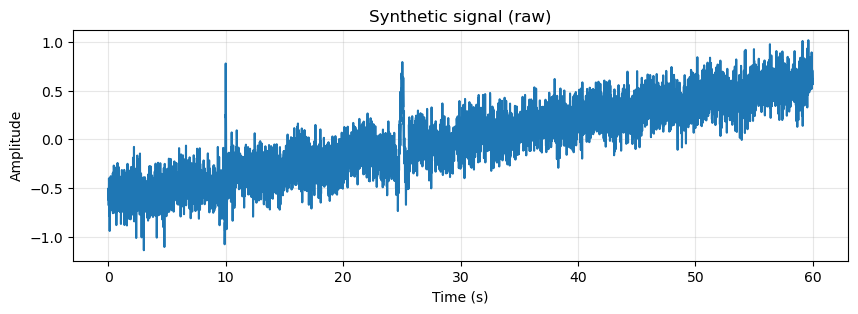

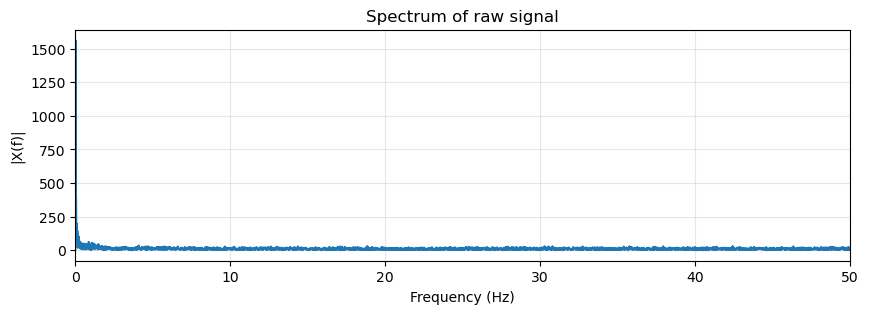

In [3]:

fs = 100.0
dt = 1/fs
T = 60.0
t = np.arange(0, T, dt)

def ricker(t, t0, f0):
    tau = t - t0
    a = (np.pi * f0 * tau)**2
    return (1 - 2*a) * np.exp(-a)

x = np.zeros_like(t)
x += 1.0 * ricker(t, 10.0, 5.0)   # P-like
x += 0.7 * ricker(t, 25.0, 1.0)   # LP-like
x += 0.02 * (t - t.mean())        # drift

rng = np.random.default_rng(0)
x += 0.15 * rng.standard_normal(len(t))
x += 0.05 * np.sin(2*np.pi*0.2*t) # microseism-ish

tr_raw = make_trace(x, fs)

plot_time(t, tr_raw.data, title="Synthetic signal (raw)")
plot_spectrum(tr_raw.data, fs, title="Spectrum of raw signal")



## 3) ObsPy filtering: one-way (causal) vs two-way (zero-phase)

ObsPy’s `Trace.filter()` supports:
- `zerophase=False` → one-way (causal) IIR filtering
- `zerophase=True`  → two-way forward/backward filtering (zero-phase, acausal)

The parameter `corners` controls filter steepness (higher corners = sharper cutoff but more ringing).


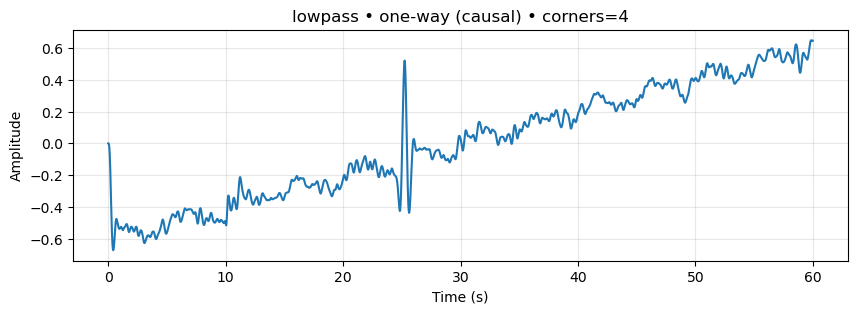

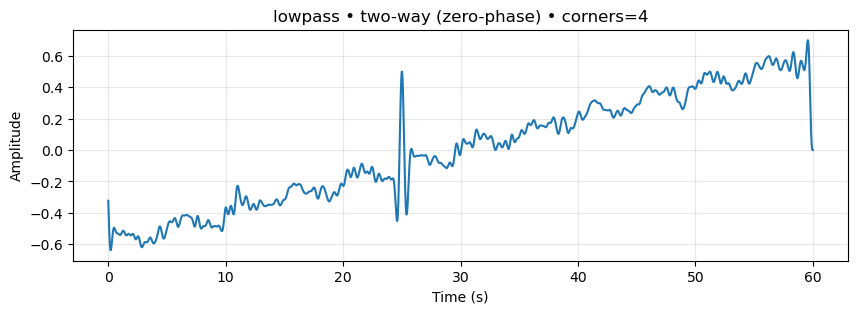

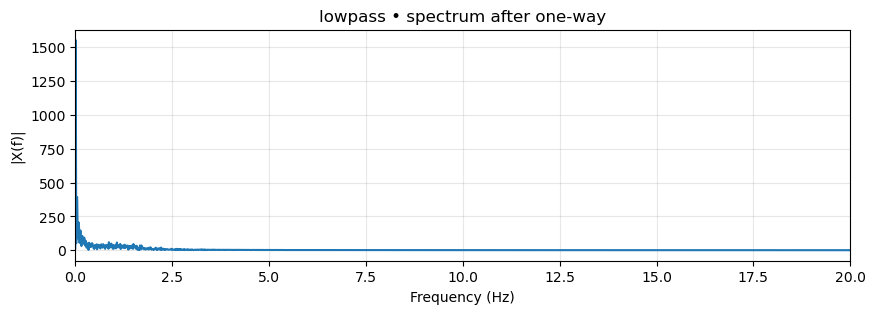

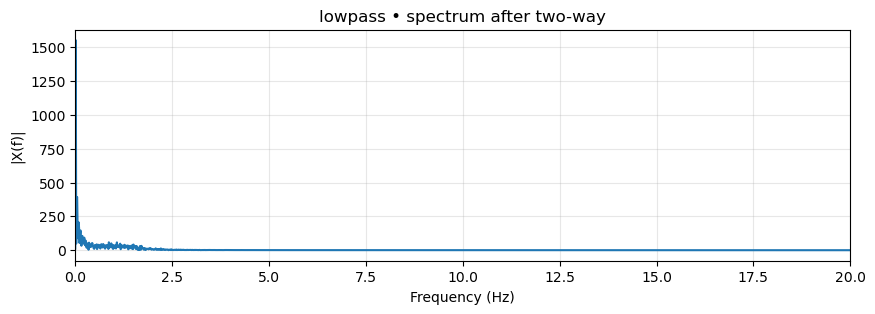

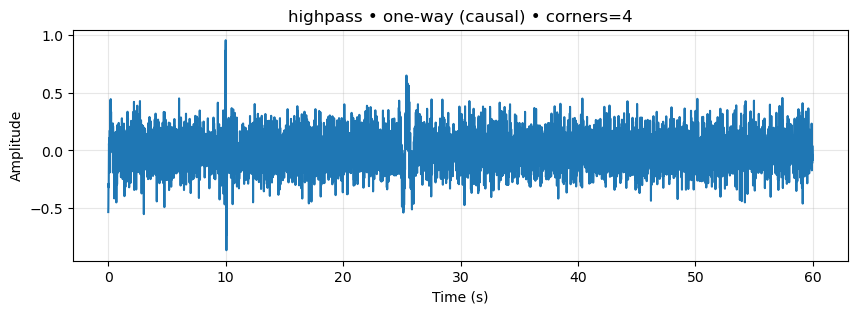

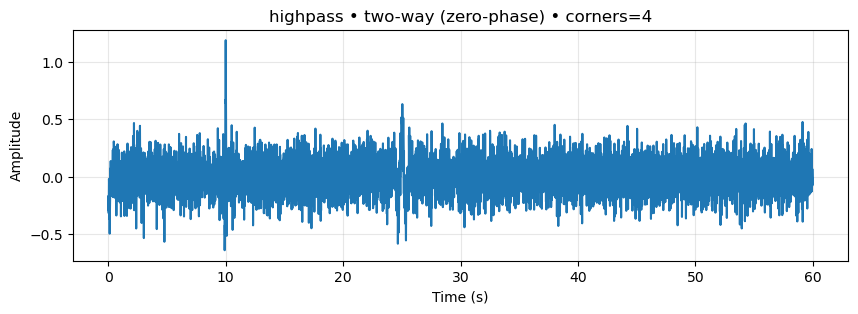

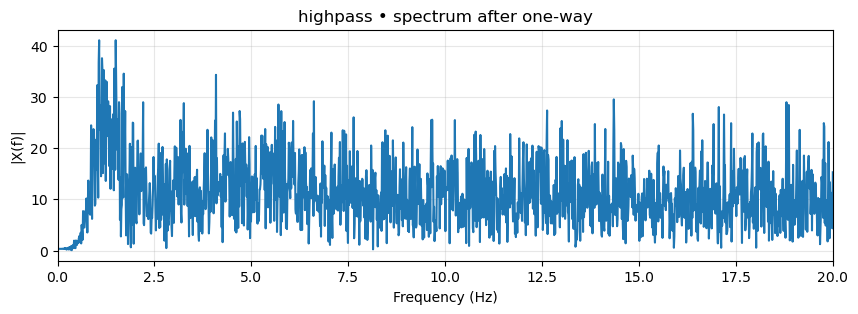

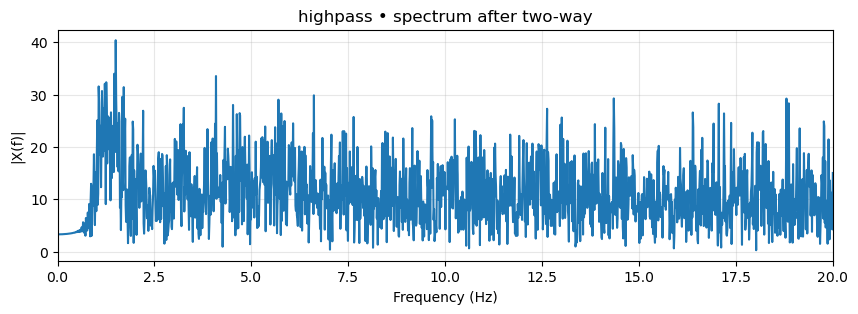

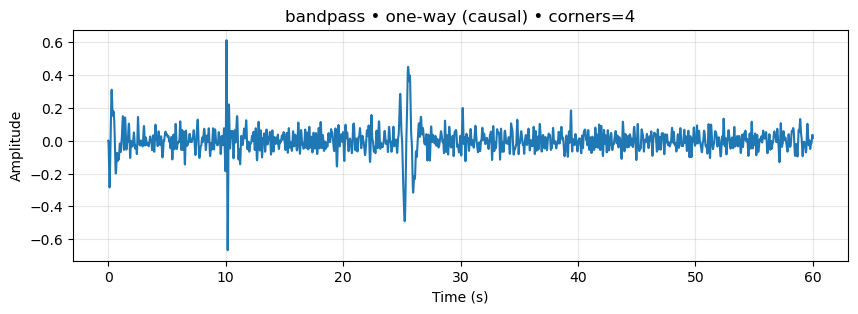

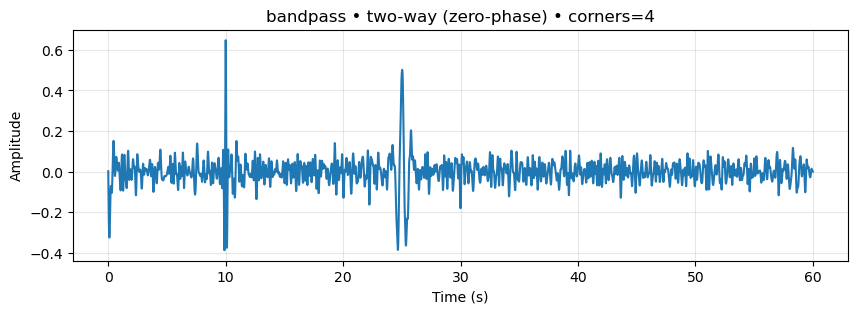

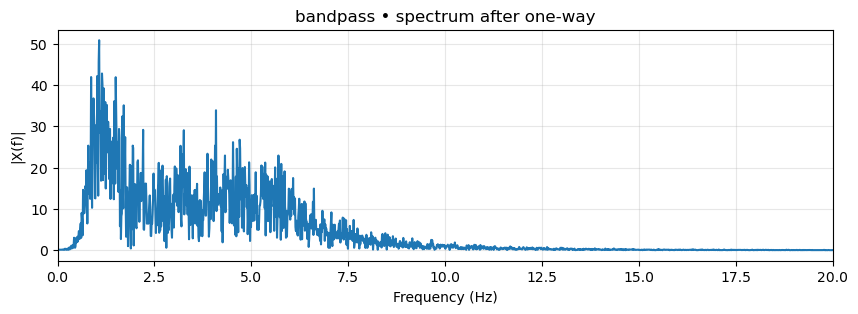

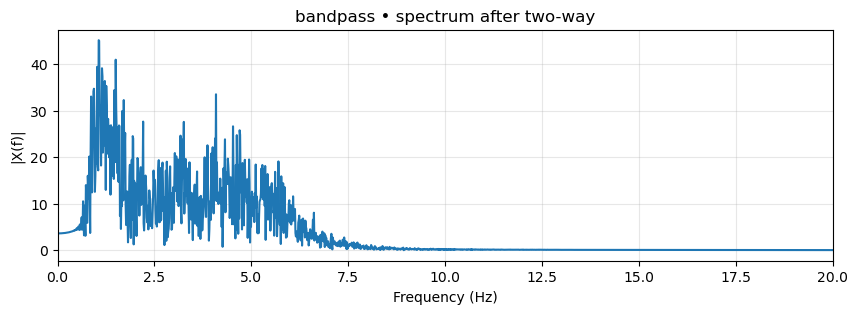

In [ ]:

def obspy_filter(tr, ftype, corners=4, zerophase=False, freq=None, freqmin=None, freqmax=None):
    out = tr.copy()
    if ftype == "lowpass":
        out.filter("lowpass", freq=freq, corners=corners, zerophase=zerophase)
    elif ftype == "highpass":
        out.filter("highpass", freq=freq, corners=corners, zerophase=zerophase)
    elif ftype == "bandpass":
        out.filter("bandpass", freqmin=freqmin, freqmax=freqmax, corners=corners, zerophase=zerophase)
    else:
        raise ValueError("ftype must be lowpass/highpass/bandpass")
    return out

# Example settings
lp_f = 2.0
hp_f = 1.0
bp_fmin, bp_fmax = 0.8, 6.0
corners = 4

examples = [
    ("lowpass", dict(freq=lp_f)),
    ("highpass", dict(freq=hp_f)),
    ("bandpass", dict(freqmin=bp_fmin, freqmax=bp_fmax)),
]

for name, kwargs in examples:
    tr_1 = obspy_filter(tr_raw, name, corners=corners, zerophase=False, **kwargs)
    tr_2 = obspy_filter(tr_raw, name, corners=corners, zerophase=True, **kwargs)

    plot_time(t, tr_1.data, title=f"{name} • one-way (causal) • corners={corners}")
    plot_time(t, tr_2.data, title=f"{name} • two-way (zero-phase) • corners={corners}")

    plot_spectrum(tr_1.data, fs, title=f"{name} • spectrum after one-way", xlim=(0, 20))
    plot_spectrum(tr_2.data, fs, title=f"{name} • spectrum after two-way", xlim=(0, 20))



### What to look for

- One-way (causal) filters typically introduce **group delay** (arrivals appear later and can be slightly smeared).
- Two-way (zero-phase) filters avoid net phase delay, but can produce **symmetric ringing** around sharp features.

That leads to the key concept in the next section: **onset smearing**.



## 4) Onset smearing (pre-ringing): why “zero-phase preserves arrival times” needs nuance

It’s common to say:

> “Zero-phase filtering preserves arrival times.”

What that usually means is:
- the filtered waveform is not systematically shifted later in time (no net phase delay)

But forward-backward filtering is **acausal**.
Its effective impulse response is **symmetric in time**, which can create **pre-ringing**:
- energy appears *before* the true physical onset

So:
- **Causal filters** do *not* create pre-onset energy, but they can **delay** the onset.
- **Zero-phase filters** do *not* delay the waveform overall, but they can **smear energy before the onset**.

Let’s demonstrate this with a very sharp onset.


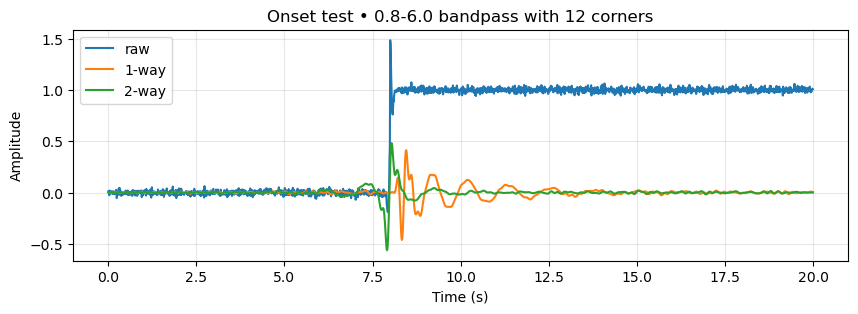

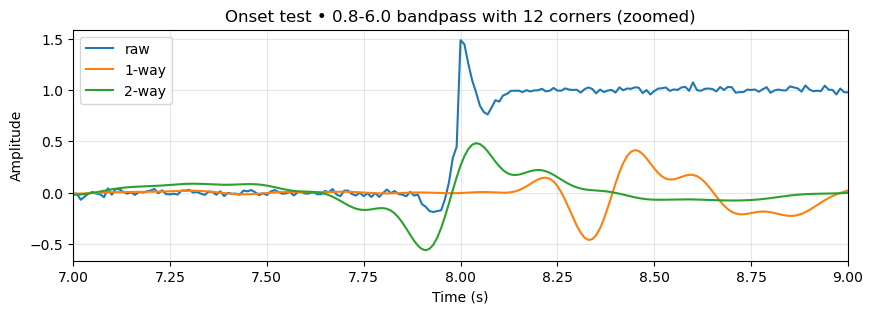

In [40]:
import obspy 
# Build a very sharp onset: a step + a short pulse, with some noise
t2 = np.arange(0, 20, 1/fs)
x2 = np.zeros_like(t2)

t_on = 8.0
x2[t2 >= t_on] += 1.0              # step onset
x2 += 0.5 * ricker(t2, t_on, 6.0)  # sharp pulse on top
x2 += 0.02 * np.random.default_rng(1).standard_normal(len(t2))

tr_on = make_trace(x2, fs)
tr_on.stats['label'] = 'raw'

# Apply bandpass both ways to make ringing obvious
corners_test = 12
tr_on_1way = tr_on.copy().filter("bandpass", corners=corners_test, zerophase=False, freqmin=bp_fmin, freqmax=bp_fmax)
tr_on_1way.stats['label'] = '1-way'

tr_on_2way = tr_on.copy().filter("bandpass", corners=corners_test/2, zerophase=True, freqmin=bp_fmin, freqmax=bp_fmax)
tr_on_2way.stats['label'] = '2-way'

st = obspy.Stream(traces=[tr_on, tr_on_1way, tr_on_2way])

def plot_stream(st, title="", xlabel="Time (s)", ylabel="Amplitude", xlim=None):
    fig, ax = plt.subplots(figsize=(10, 3))
    for tr in st:
        t = tr.times()
        x = tr.data
        ax.plot(t, x, label=tr.stats.label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if xlim is not None:
        ax.set_xlim(*xlim)
    plt.legend()
    plt.show()

plot_stream(st, title=f"Onset test • {bp_fmin}-{bp_fmax} bandpass with {corners_test} corners")#, xlim=(7, 9))
plot_stream(st, title=f"Onset test • {bp_fmin}-{bp_fmax} bandpass with {corners_test} corners (zoomed)", xlim=(7, 9))



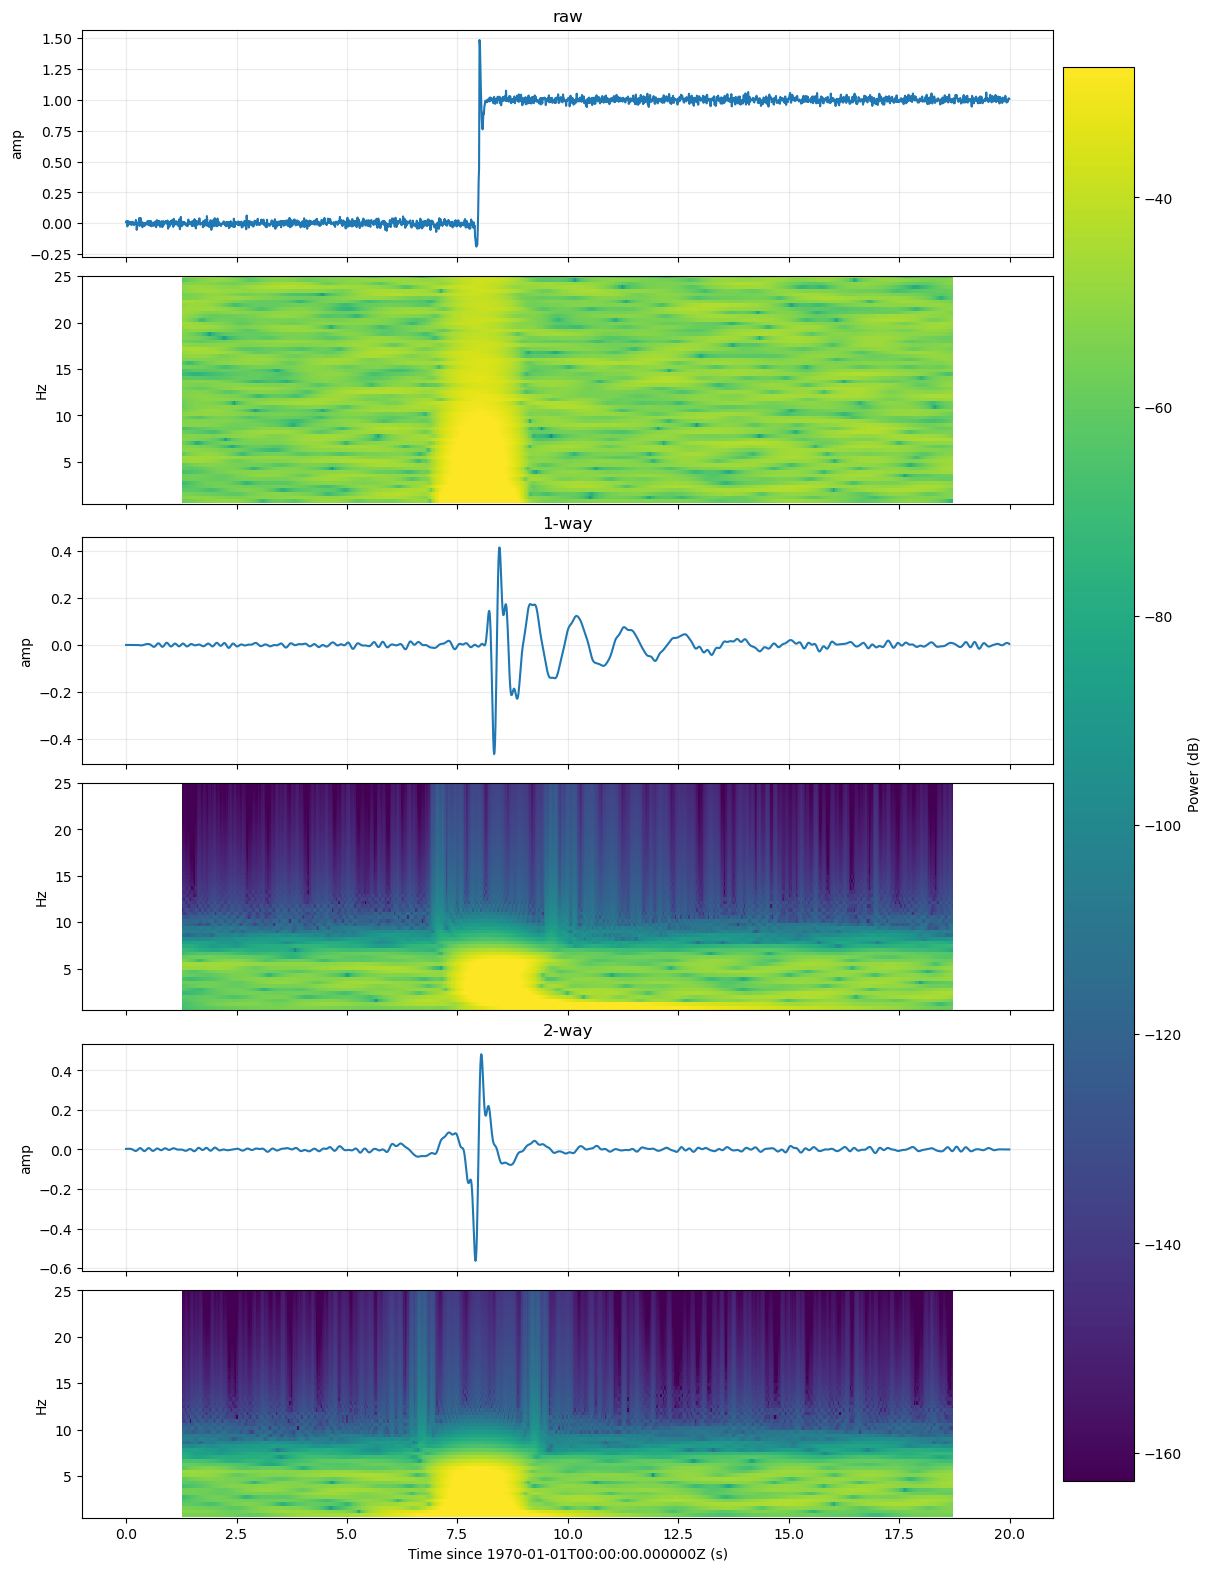

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def plot_stream_spectrograms(
    st,
    starttime=None,
    endtime=None,
    fmin=0.0,
    fmax=None,
    nperseg=None,
    noverlap=0.95,
    detrend="constant",
    window="hann",
    scaling="density",
    mode="psd",
    db=True,
    clim=None,              # (vmin, vmax) in dB (or linear if db=False)
    common_clim=True,       # same color limits across traces
    cmap="viridis",
    show_waveform=False,    # add waveform above each spectrogram
    figsize=(12, 2.6),
):
    """
    Plot spectrograms for all traces in an ObsPy Stream as stacked subplots.

    Zooming:
    - In Jupyter, matplotlib toolbar zoom/pan works.
    - You can also set starttime/endtime and fmin/fmax.

    Notes:
    - Times are plotted as seconds from the chosen starttime.
    - Uses scipy.signal.spectrogram; good control over FFT params.
    """
    if len(st) == 0:
        raise ValueError("Stream is empty")

    # Work on a copy so we don't mutate the caller's stream
    st2 = st.copy()

    # Decide time window
    if starttime is None:
        starttime = min(tr.stats.starttime for tr in st2)
    if endtime is None:
        endtime = max(tr.stats.endtime for tr in st2)

    st2.trim(starttime=starttime, endtime=endtime, pad=True, fill_value=0.0)

    # Choose fs and FFT params per trace (we compute individually)
    specs = []  # (f, t, Sxx_db or linear)
    titles = []

    for tr in st2:
        x = tr.data.astype(np.float64)
        fs = float(tr.stats.sampling_rate)

        if nperseg is None:
            # rule of thumb: ~2 s window, but at least 256 samples
            nperseg_i = max(int(fs * 2.0), 256)
        else:
            nperseg_i = int(nperseg)

        noverlap_i = int(noverlap * nperseg_i)

        f, tt, Sxx = spectrogram(
            x,
            fs=fs,
            window=window,
            nperseg=nperseg_i,
            noverlap=noverlap_i,
            detrend=detrend,
            scaling=scaling,
            mode=mode,
        )

        # Convert time axis to seconds from starttime
        # spectrogram's tt is seconds from trace start (which equals our starttime after trim)
        # so it's already relative to starttime.
        if db:
            S = 10.0 * np.log10(np.maximum(Sxx, 1e-20))
        else:
            S = Sxx

        specs.append((f, tt, S, tr))
        label = getattr(tr.stats, "label", None)
        titles.append(label if label else f"{tr.id}")

    # Decide fmax default (Nyquist min across traces)
    if fmax is None:
        fmax = min(0.5 * float(tr.stats.sampling_rate) for _, _, _, tr in specs)

    # Determine common color limits
    if common_clim:
        all_vals = []
        for f, tt, S, tr in specs:
            fm = (f >= fmin) & (f <= fmax)
            all_vals.append(S[fm, :])
        all_vals = np.concatenate([a.ravel() for a in all_vals])
        if clim is None:
            # robust range: 2–98 percentile
            vmin, vmax = np.percentile(all_vals, [2, 98])
        else:
            vmin, vmax = clim
    else:
        vmin = vmax = None  # per-trace below

    n = len(specs)
    rows = n
    extra = 1 if show_waveform else 0
    total_rows = rows * (1 + extra)

    fig, axes = plt.subplots(
        nrows=total_rows,
        ncols=1,
        figsize=(figsize[0], figsize[1] * total_rows),
        sharex=True,
        constrained_layout=True,
    )

    if total_rows == 1:
        axes = [axes]

    # Helper: find axis index for each trace
    def ax_idx(i, is_wave):
        if show_waveform:
            base = i * 2
            return base if is_wave else base + 1
        return i

    mappable = None

    for i, (f, tt, S, tr) in enumerate(specs):
        # Frequency mask for plotting
        fm = (f >= fmin) & (f <= fmax)
        f_plot = f[fm]
        S_plot = S[fm, :]

        # Per-trace clim if needed
        if not common_clim:
            if clim is None:
                vmin_i, vmax_i = np.percentile(S_plot.ravel(), [2, 98])
            else:
                vmin_i, vmax_i = clim
        else:
            vmin_i, vmax_i = vmin, vmax

        # Optional waveform
        if show_waveform:
            axw = axes[ax_idx(i, True)]
            t_axis = np.arange(tr.stats.npts) / float(tr.stats.sampling_rate)
            axw.plot(t_axis, tr.data)
            axw.set_ylabel("amp")
            axw.set_title(titles[i])
            axw.grid(True, alpha=0.25)

        axs = axes[ax_idx(i, False)]
        # Use pcolormesh for zoomable plots
        mappable = axs.pcolormesh(tt, f_plot, S_plot, shading="auto",
                                  vmin=vmin_i, vmax=vmax_i, cmap=cmap)
        axs.set_ylabel("Hz")
        if not show_waveform:
            axs.set_title(titles[i])

        # Apply y-limits explicitly for zoom framing
        axs.set_ylim(fmin, fmax)

    axes[-1].set_xlabel(f"Time since {starttime} (s)")

    # Add one shared colorbar
    cbar = fig.colorbar(mappable, ax=axes, location="right", pad=0.01, shrink=0.95)
    cbar.set_label("Power (dB)" if db else "Power")

    return fig, axes


fig, axes = plot_stream_spectrograms(
    st,
    fmin=0.5,
    fmax=25,
    show_waveform=True, 
    noverlap=0.99  # optional
)
plt.show()


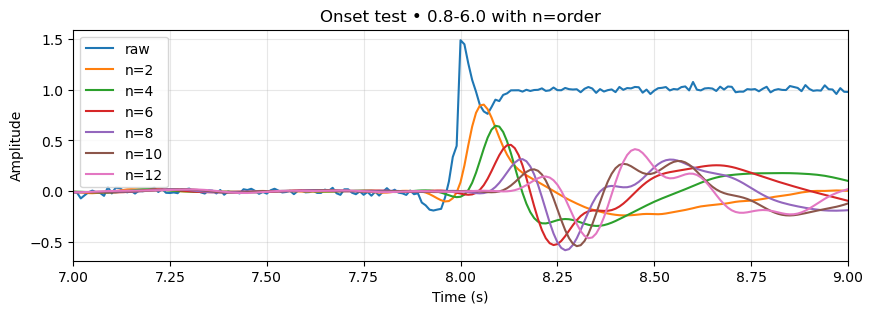

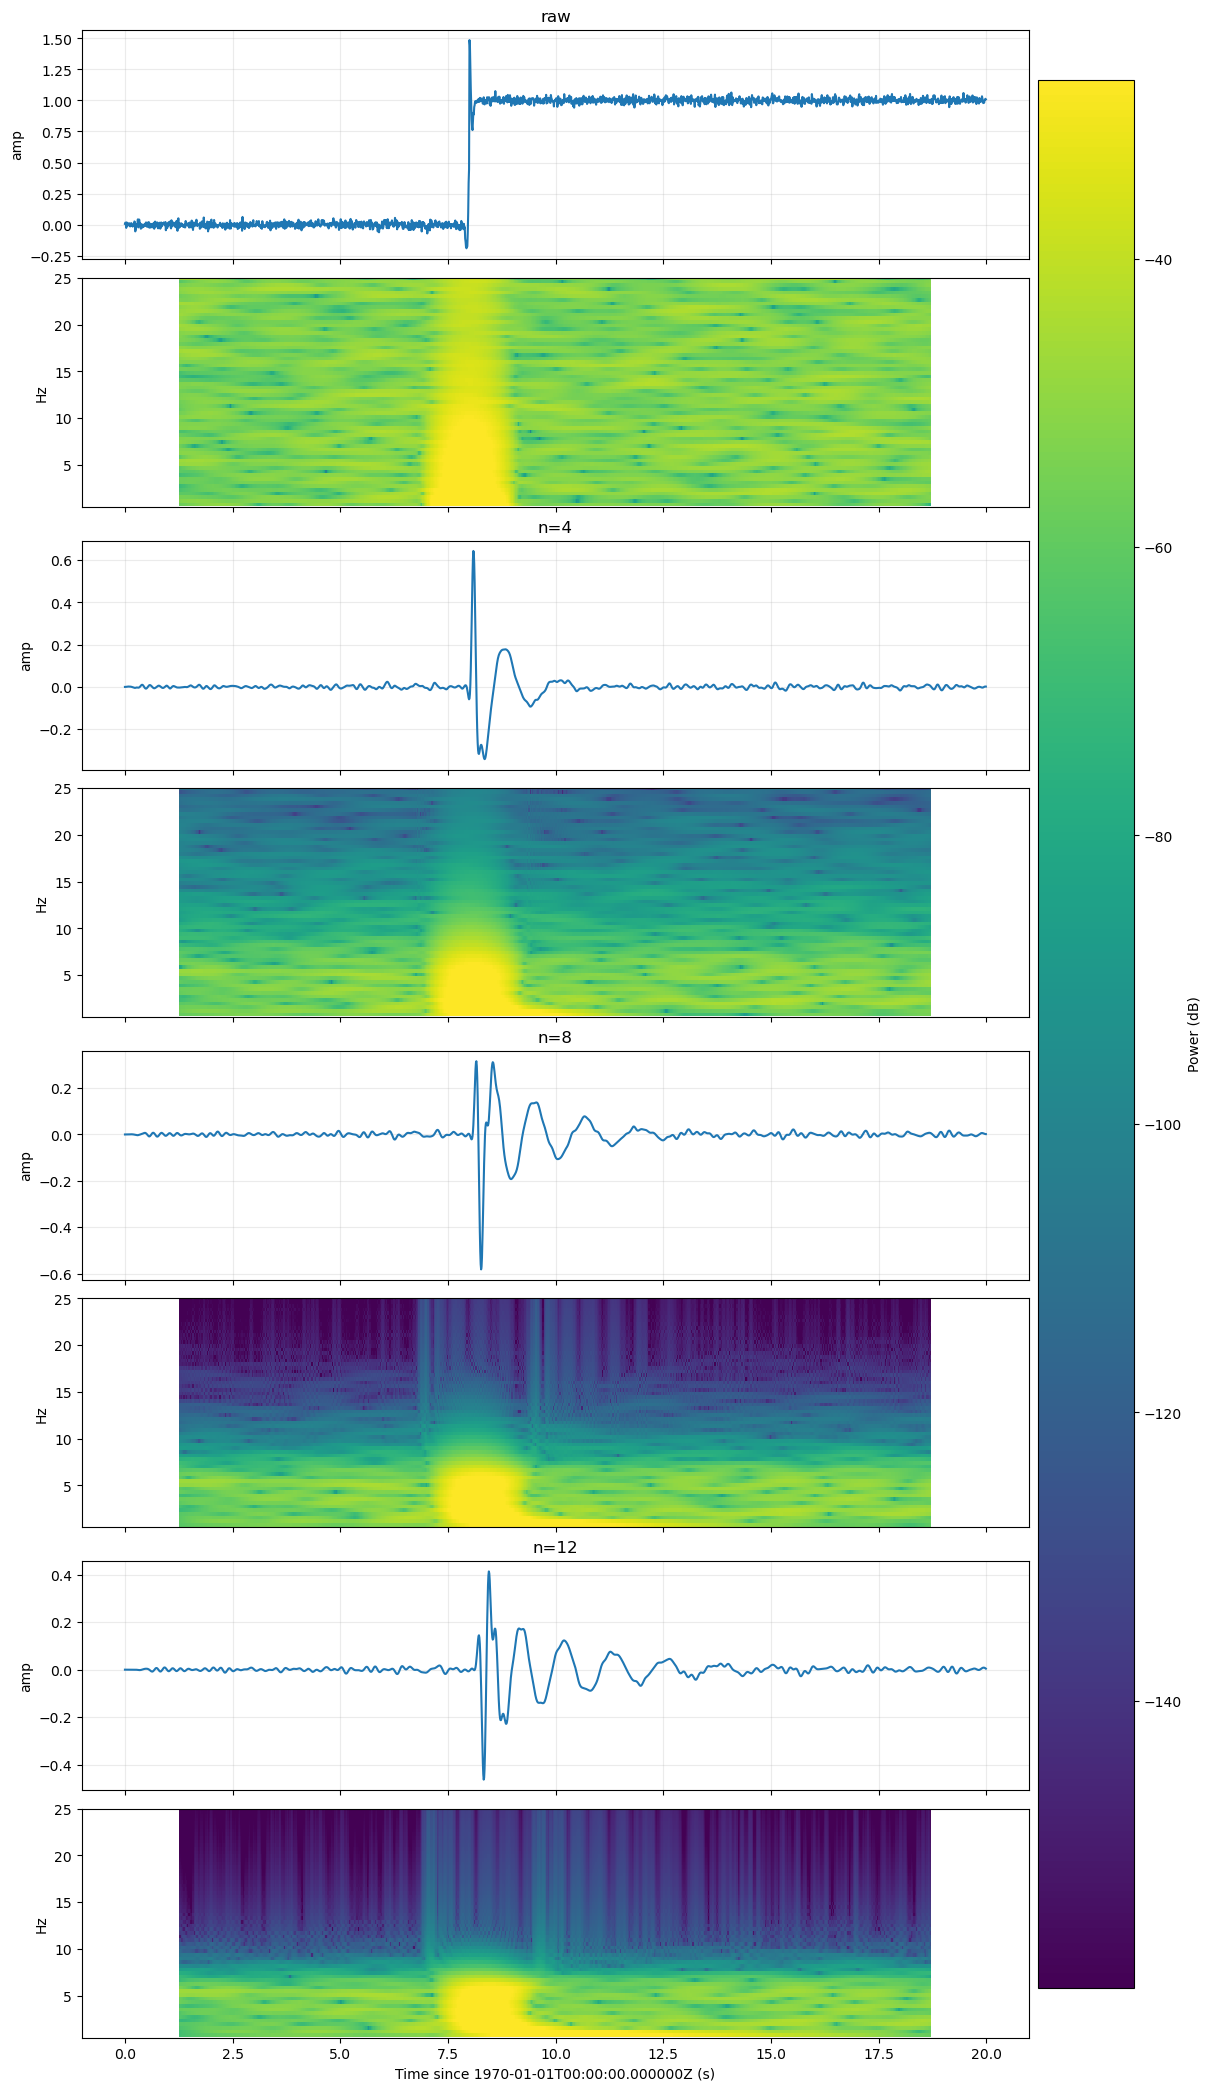

In [ ]:
st2 = obspy.Stream(traces=[tr_on])
for corners_test in range(2,13,2):
    tr_tmp = tr_on.copy().filter("bandpass", corners=corners_test, zerophase=False, freqmin=bp_fmin, freqmax=bp_fmax)
    tr_tmp.stats['label'] = f'n={corners_test}'
    st2.append(tr_tmp)

plot_stream(st2, title=f"Onset test • {bp_fmin}-{bp_fmax} with n=order", xlim=(7, 9))

fig, axes = plot_stream_spectrograms(
    obspy.Stream(traces=st2[::2]),
    fmin=0.5,
    fmax=25,
    show_waveform=True, 
    noverlap=0.99  # optional
)
plt.show()


### Takeaway for picking arrivals

If you are picking **first-break** arrivals (the earliest onset):

- **Causal filtering** is conceptually safer: it cannot create energy before the onset.
- But causal filters can **delay** the onset, sometimes by an amount that depends on frequency.

If you are doing **offline waveform alignment**, **template matching**, or making clean-looking plots:

- **Zero-phase** filtering is often preferred because it avoids phase distortion.
- But you should be aware of **pre-ringing** (especially with narrow bands or high order).

Rule-of-thumb:
> Zero-phase avoids net time shifts, but can create pre-ringing; causal preserves causality, but introduces delay.


## 5) Filter order/corners: sharper cutoff vs more ringing (ObsPy)

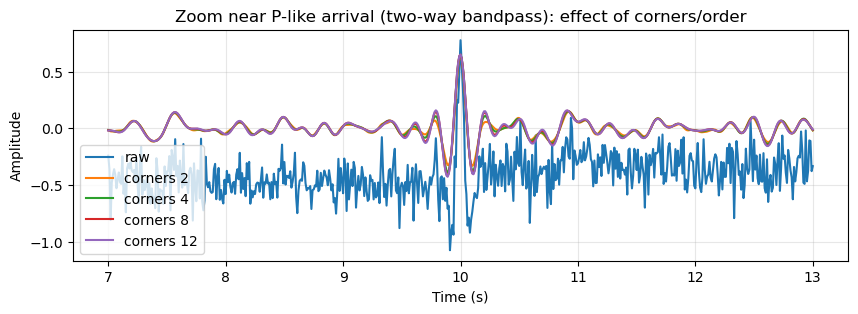

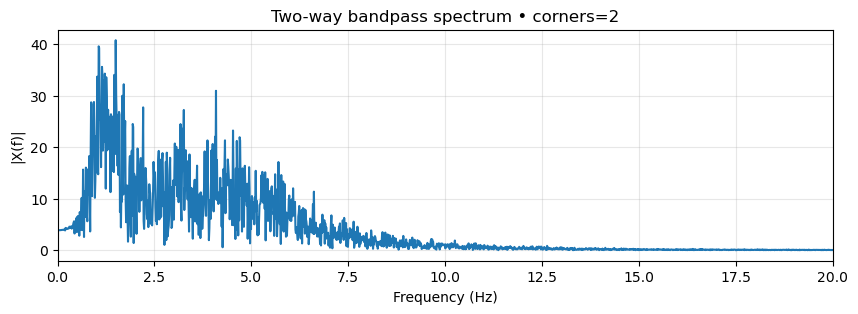

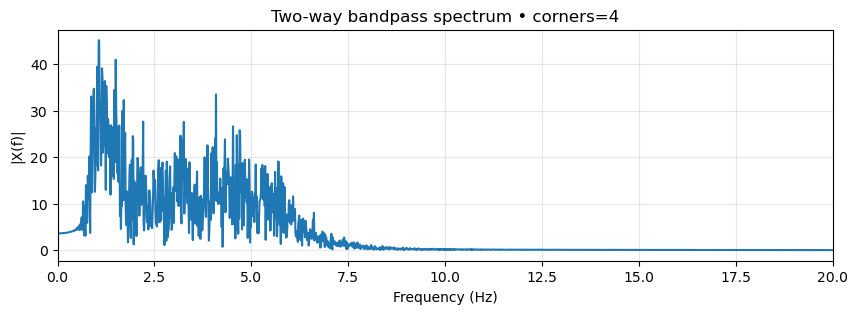

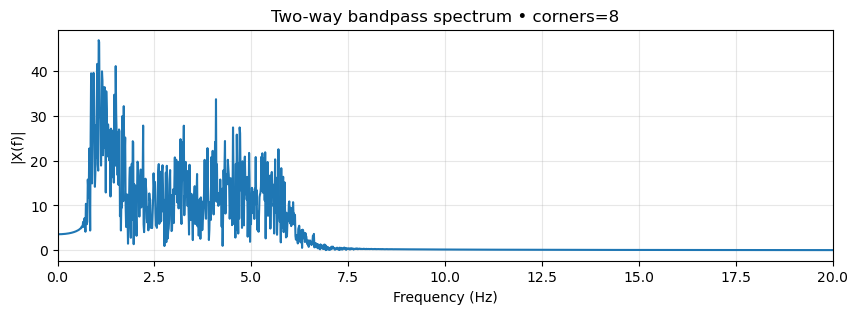

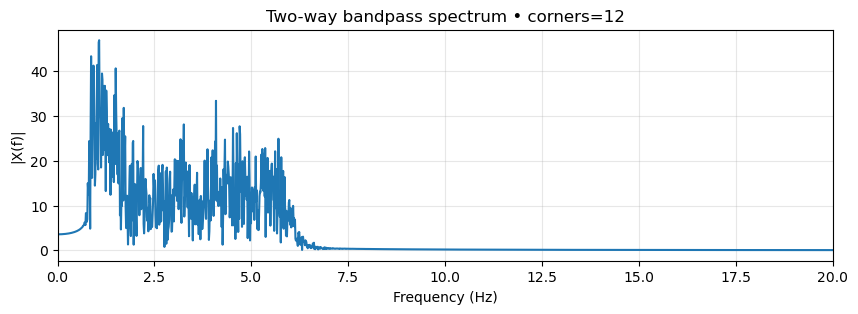

In [6]:

orders = [2, 4, 8, 12]  # ObsPy calls this 'corners'

# Compare two-way bandpass outputs for different corners
t0, t1 = 7, 13
mask = (t >= t0) & (t <= t1)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t[mask], tr_raw.data[mask], label="raw")
for c in orders:
    tr_tmp = obspy_filter(tr_raw, "bandpass", corners=c, zerophase=True, freqmin=bp_fmin, freqmax=bp_fmax)
    ax.plot(t[mask], tr_tmp.data[mask], label=f"corners {c}")
ax.set_title("Zoom near P-like arrival (two-way bandpass): effect of corners/order")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

# Frequency-domain comparison
for c in orders:
    tr_tmp = obspy_filter(tr_raw, "bandpass", corners=c, zerophase=True, freqmin=bp_fmin, freqmax=bp_fmax)
    plot_spectrum(tr_tmp.data, fs, title=f"Two-way bandpass spectrum • corners={c}", xlim=(0, 20))



**What to notice:**
- Higher `corners` → sharper transition bands (better separation)
- Higher `corners` → more ringing and more sensitivity to sharp transients
- Two-way filtering can make ringing more symmetric and more obvious

In practice:
- start with modest corners (e.g., 2–4)
- avoid very narrow bands unless you really need them



## 6) Minimum-phase vs zero-phase (conceptual wrap-up)

- **Zero-phase** in this notebook is achieved by forward-backward filtering (`zerophase=True`).
  - Great for offline analysis and display
  - Not usable in real time
  - Can create pre-ringing (“onset smearing”)

- **Minimum-phase** filters are causal/stable designs that minimize group delay for a given magnitude response.
  - In practice you encounter “minimum-phase” choices in digitizers/decimation filters, where latency matters.

We won’t implement minimum-phase spectral factorization here (that’s a more advanced DSP topic),
but you should understand the tradeoff:
- minimum-phase: causal, low-latency, phase distortion
- zero-phase: no net phase distortion, acausal, pre-ringing possible



## 7) Analog vs digital: what’s different at the end of the day?

### Analog (continuous-time) intuition
- Filters described by \(H(s)\) (poles/zeros in the s-plane)
- Always causal
- Hardware limits + noise + component tolerances

### Digital (discrete-time) reality
- Filters described by \(H(z)\) (poles/zeros in the z-plane)
- Depend on sampling rate (Nyquist)
- Can be applied causally (one-way) or acausally (two-way)

### Seismology-specific note
Digitizers commonly use **FIR decimation** filters, and often offer:
- a **linear-phase** option (more delay)
- a **minimum-phase/causal** option (less delay)

Those choices matter for real-time triggering versus offline analysis.
